# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:

import os
import torch
import numpy as np
from six.moves import urllib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#os.chdir(r"C:\Users\Shafufu\Desktop\Huacheng Doc\HL Python Learning\Udacity\04 Deep Learning\Project_2_landmark\landmarks")
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_scratch = {'train': None, 'valid': None, 'test': None}
data_dir = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes_dict = {i: j.split(".")[1] for i,j in enumerate(sorted(os.listdir(train_dir)))} # return name for a given label
classes = list(classes_dict.values())

normalize_mean = np.array([0.5, 0.5, 0.5])
normalize_std = np.array([0.5, 0.5, 0.5])

def data_transforms():
    data_transforms = {}
    data_transforms["train"] = transforms.Compose([
                                           transforms.RandomChoice([
                                               transforms.RandomRotation(180),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5)]),
                                           transforms.RandomResizedCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(normalize_mean,normalize_std)])

    data_transforms["test"]  = transforms.Compose([
                                           transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(normalize_mean,normalize_std)])
    return(data_transforms)
data_transforms = data_transforms()

def image_datasets(data_dir, data_transforms):
    image_datasets = {}
    image_datasets["train"] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms["train"])
    image_datasets["test"]  = datasets.ImageFolder(data_dir + '/test' , transform=data_transforms["test"])
    return image_datasets
image_datasets = image_datasets(data_dir, data_transforms)


def dataloaders(image_datasets):
    num_train = len(image_datasets["train"])
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(0.2 * num_train))  #valid_size = 0.2
    train_idx, valid_idx = indices[split:], indices[:split]
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)                        
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    dataloaders = {}
    dataloaders["train"] = torch.utils.data.DataLoader(image_datasets["train"], batch_size=32, sampler=train_sampler)
    dataloaders["valid"] = torch.utils.data.DataLoader(image_datasets["train"], batch_size=32, sampler=valid_sampler)
    dataloaders["test"]  = torch.utils.data.DataLoader(image_datasets["test"],  batch_size=32, shuffle=False)
    return dataloaders
loaders_scratch = dataloaders(image_datasets)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1. The resize for the scratch model can be arbitrary. But to make it an apple-to-apple comparison with the transfer learning version model, inputs are resized to 224 x 224.
2. Dataset is augmented by adding rotation, flip, and randomly centered the input images. Hopefully, it can help the performance on testing samples.  


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

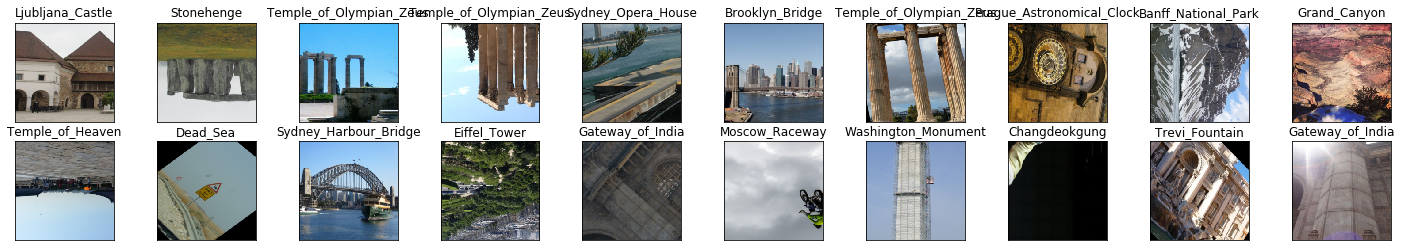

In [5]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize 因为 Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
if torch.cuda.is_available():
    train_on_gpu=True
    use_cuda=True
    device = torch.device("cuda")
    #model.cuda()  # or model.to(device)
else:
    train_on_gpu=False
    use_cuda=False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
import torch.nn as nn
import torch.nn.functional as F

criterion_scratch = nn.NLLLoss() 

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return(optimizer)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 3x224x224 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) 
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 1000)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(1000, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))               
        x = self.pool(F.relu(self.conv2(x)))                
        x = self.pool(F.relu(self.conv3(x)))                
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.rrelu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

**Answer**: 

1. The purpose of the CNN architecture is to downsize each and every feature maps, and increase the number(depth) of feature maps. The input image is 224 x 224. Therefore, three pooling layers, each with a stride of 2, will bring the size down to 28*28.   

2. At the same time, the depth of the features maps inceased from 16 to 32 and finally to 64. I'd like to try a alternative combination, such as depth of 128 with feature map size 14 x 14. However, due to the limited GPU hours, the test run is omitted.  

3. Two fully connect layers were added to the end of the model. The first layer used RRelu while the second used the Relu, which is based on the previous project experience. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss,valid_loss ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    
    classname = m.__class__.__name__
    # for the two Linear layers
    if classname.find('Linear') != -1:
        num_inputs = m.in_features
        y= 1.0/np.sqrt(num_inputs) # general rule
        m.weight.data.uniform_(-y , y) 
        m.bias.data.fill_(0)


#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.910830 	Validation Loss: 3.907295
Validation loss decreased (inf --> 3.907295).  Saving model ...
Epoch: 2 	Training Loss: 3.898010 	Validation Loss: 3.890761
Validation loss decreased (3.907295 --> 3.890761).  Saving model ...
Epoch: 3 	Training Loss: 3.861372 	Validation Loss: 3.843524
Validation loss decreased (3.890761 --> 3.843524).  Saving model ...
Epoch: 4 	Training Loss: 3.830251 	Validation Loss: 3.819046
Validation loss decreased (3.843524 --> 3.819046).  Saving model ...
Epoch: 5 	Training Loss: 3.806127 	Validation Loss: 3.802266
Validation loss decreased (3.819046 --> 3.802266).  Saving model ...
Epoch: 6 	Training Loss: 3.783736 	Validation Loss: 3.765464
Validation loss decreased (3.802266 --> 3.765464).  Saving model ...
Epoch: 7 	Training Loss: 3.760366 	Validation Loss: 3.757093
Validation loss decreased (3.765464 --> 3.757093).  Saving model ...
Epoch: 8 	Training Loss: 3.728580 	Validation Loss: 3.727835
Validation loss decreased (3.75709

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.911744 	Validation Loss: 3.909213
Validation loss decreased (inf --> 3.909213).  Saving model ...
Epoch: 2 	Training Loss: 3.902028 	Validation Loss: 3.898590
Validation loss decreased (3.909213 --> 3.898590).  Saving model ...
Epoch: 3 	Training Loss: 3.872938 	Validation Loss: 3.862065
Validation loss decreased (3.898590 --> 3.862065).  Saving model ...
Epoch: 4 	Training Loss: 3.821921 	Validation Loss: 3.833194
Validation loss decreased (3.862065 --> 3.833194).  Saving model ...
Epoch: 5 	Training Loss: 3.795368 	Validation Loss: 3.814147
Validation loss decreased (3.833194 --> 3.814147).  Saving model ...
Epoch: 6 	Training Loss: 3.782506 	Validation Loss: 3.788270
Validation loss decreased (3.814147 --> 3.788270).  Saving model ...
Epoch: 7 	Training Loss: 3.750839 	Validation Loss: 3.753507
Validation loss decreased (3.788270 --> 3.753507).  Saving model ...
Epoch: 8 	Training Loss: 3.712302 	Validation Loss: 3.720446
Validation loss decreased (3.75350

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [11]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.114528


Test Accuracy: 22% (287/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from collections import OrderedDict
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = dataloaders(image_datasets)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: select loss function
criterion_transfer = nn.NLLLoss() 


def freeze_parameters(root, freeze=True):
    [param.requires_grad_(not freeze) for param in root.parameters()]

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    freeze_parameters(model)
    try: # some model final layer is called 'fc', while others are call 'classifier'
        freeze_parameters(model.fc, False)
        optimizer = torch.optim.Adagrad(model.fc.parameters(), lr=0.015, weight_decay=0.001)
    except AttributeError:
        freeze_parameters(model.classifier, False)
        optimizer = torch.optim.Adagrad(model.classifier.parameters(), lr=0.015, weight_decay=0.001)
    #optimizer = torch.optim.Adagrad(model.classifier.parameters(), lr=0.01, weight_decay=0.001)
    return(optimizer)  
  

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [13]:
## TODO: Specify model architecture

def customize_classifer (model_name = "vgg13", set_classifer_hiddensize=500,finalclass=50, dropout=0.5):
    model = getattr(models, model_name)(pretrained=True)   
    for param in model.parameters():
        param.requires_grad = False
    classifier_name, old_classifier = model._modules.popitem()
    try:
        old_classifier=old_classifier[0] # when model is vgg13
    except TypeError:
        pass
    classifier_input_size = old_classifier.in_features
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(classifier_input_size, set_classifer_hiddensize)),
                          ('relu', nn.RReLU()),
                          ('drop',nn.Dropout(p=dropout)),
                          ('fc2', nn.Linear(set_classifer_hiddensize,finalclass)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.add_module(classifier_name, classifier)
    return model

model_name='vgg16'
set_classifer_hiddensize=500
finalclass=len(classes)


model_transfer = customize_classifer (model_name = model_name,
                     set_classifer_hiddensize=set_classifer_hiddensize,
                     finalclass=finalclass)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 110184100.96it/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

1. The final classifier/fc layer was replaced, to accommodate the 50 classes landmark data. 
2. Flattened final features maps was fed into the fc1 fully connected hidden layer, with 500 output nodes. 
3. The hidden layer activated with RReLU, then input to final layer, with 50 classes of output cateogries.
4. It is verly likely that the feature maps from the Convolutional layers adequately capture the characteristics of the figures, there is large room for selecting the specification of the classification/FC layer to reach 60% accuracy.   


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

model_transfer = train(20, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 11.928748 	Validation Loss: 4.364926
Validation loss decreased (inf --> 4.364926).  Saving model ...
Epoch: 2 	Training Loss: 4.089814 	Validation Loss: 3.074923
Validation loss decreased (4.364926 --> 3.074923).  Saving model ...
Epoch: 3 	Training Loss: 3.195812 	Validation Loss: 2.721533
Validation loss decreased (3.074923 --> 2.721533).  Saving model ...
Epoch: 4 	Training Loss: 2.658365 	Validation Loss: 2.386682
Validation loss decreased (2.721533 --> 2.386682).  Saving model ...
Epoch: 5 	Training Loss: 2.455393 	Validation Loss: 2.088572
Validation loss decreased (2.386682 --> 2.088572).  Saving model ...
Epoch: 6 	Training Loss: 2.164211 	Validation Loss: 2.224062
Epoch: 7 	Training Loss: 1.981376 	Validation Loss: 1.954008
Validation loss decreased (2.088572 --> 1.954008).  Saving model ...
Epoch: 8 	Training Loss: 1.846496 	Validation Loss: 1.917154
Validation loss decreased (1.954008 --> 1.917154).  Saving model ...
Epoch: 9 	Training Loss: 1.787757

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [10]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.041411


Test Accuracy: 75% (941/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image
import torchvision.transforms.functional as TF
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    transform = data_transforms["test"]
    image= transform(image)
    image.unsqueeze_(0)
  
    if use_cuda:
        image = image.cuda()
        
    with torch.no_grad():
        model_transfer.eval()
        image = image.view(1,3,224,224)
        image = image.to(device)
        predictions = model_transfer.forward(image)
        predictions = torch.exp(predictions)
        top_ps, top_class = predictions.topk(k, dim=1)
        class_result = [classes[i] for i in top_class[0].cpu().numpy()]
    return  class_result  

#/data/landmark_images/
# test on a sample image
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
predict_landmarks(img_path='./images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', k=5)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Sydney_Harbour_Bridge',
 'Brooklyn_Bridge',
 'Dead_Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

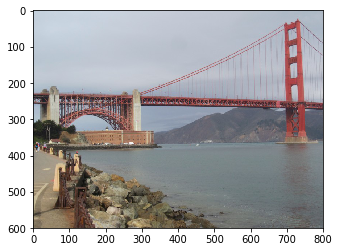

Is this picture of the Golden_Gate_Bridge , Forth_Bridge , or Sydney_Harbour_Bridge


In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)

    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this picture of the',predicted_landmarks[0],',', predicted_landmarks[1],', or', predicted_landmarks[2])

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. Larger classifier layers. Increasing the hidden layer to 1000 could improve the performance. 
2. Larger epoch should be used when more GPU hours are available
3. Learning rate is holding constant. There are several alterantive learning rate tricks could be used to enhance the model.  

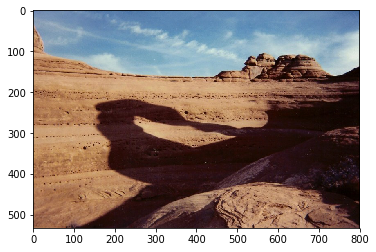

Is this picture of the Badlands_National_Park , Delicate_Arch , or Death_Valley_National_Park


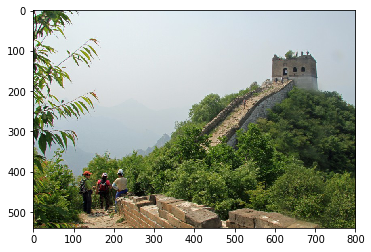

Is this picture of the Great_Wall_of_China , Machu_Picchu , or Edinburgh_Castle


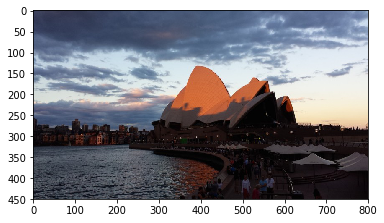

Is this picture of the Sydney_Opera_House , Monumento_a_la_Revolucion , or Sydney_Harbour_Bridge


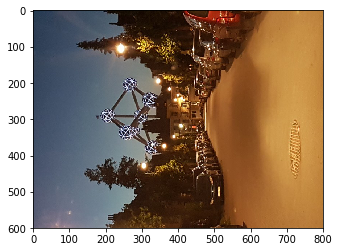

Is this picture of the Eiffel_Tower , Vienna_City_Hall , or London_Olympic_Stadium


In [17]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
# Model is too big for my GPU, so I randomly selected 4 pictures from the test folder
import random
for i in range(4):
    folder = random.choice(os.listdir(test_dir))
    image_file = random.choice(os.listdir(os.path.join(test_dir, folder)))
    image_path = test_dir + f'/{folder}/{image_file}'
    suggest_locations(image_path)